In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import joblib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('/content/Restaurant_Reviews.tsv', delimiter='\t')

In [3]:
data.shape

(1000, 2)

In [4]:
data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [5]:
corpus = []
for i in range(0,1000):
  review = re.sub('[^a-zA-Z]', ' ', data['Review'][i])
  review = review.lower()
  review = review.split()
  stemmer = PorterStemmer()
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')
  review = [stemmer.stem(word) for word in review if not word in set(all_stopwords)]
  review = ' '.join(review)
  corpus.append(review)
  if data['Liked'][i] == 1:
    data['Liked'][i] = 'Positive'
  else:
    data['Liked'][i] = 'Negative'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [6]:
data['cleaned_text']=corpus

In [7]:
data.head()

,Review,Liked,cleaned_text
0,Wow... Loved this place.,Positive,wow love place
1,Crust is not good.,Negative,crust not good
2,Not tasty and the texture was just nasty.,Negative,not tasti textur nasti
3,Stopped by during the late May bank holiday of...,Positive,stop late may bank holiday rick steve recommen...
4,The selection on the menu was great and so wer...,Positive,select menu great price


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


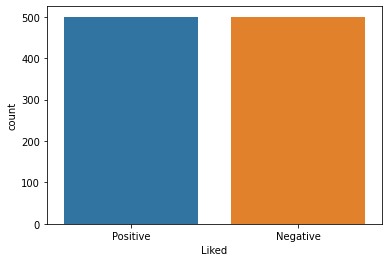

In [8]:
sns.countplot(data['Liked'])

Its a balanced data set.

##Splitting data into train and test sets

In [9]:
X_train,X_test,y_train,y_test = train_test_split(data['cleaned_text'],data['Liked'],test_size=0.2,random_state=0)

#Method 1

##Fitting Bag of Words Model

In [10]:
cv = CountVectorizer(max_features=1420)
X_train_1 = cv.fit_transform(X_train).toarray()
X_test_1 = cv.transform(X_test).toarray()

##Fitting (Naive Bayes Model)

In [11]:
Bayes_classifier = GaussianNB()
Bayes_classifier.fit(X_train_1,y_train)
pred = Bayes_classifier.predict(X_test_1)
print(confusion_matrix(y_test,pred))
accuracy_score(y_test,pred)

[[55 42]
 [12 91]]


0.73

##Fitting (SVC Model)

In [12]:
svc_classifier = SVC(kernel='rbf')
svc_classifier.fit(X_train_1,y_train)
svc_pred = svc_classifier.predict(X_test_1)
print(confusion_matrix(y_test,svc_pred))
accuracy_score(y_test,svc_pred)


[[87 10]
 [34 69]]


0.78

##Fitting (RandomForestClassifier Model)

In [13]:
RFC = RandomForestClassifier(n_estimators=150)
RFC.fit(X_train_1,y_train)
RFC_pred = RFC.predict(X_test_1)
print(confusion_matrix(y_test,RFC_pred))
accuracy_score(y_test,RFC_pred)

[[89  8]
 [40 63]]


0.76

##Fitting (Logistic Regression Model)

In [14]:
LC = LogisticRegression()
LC.fit(X_train_1,y_train)
LC_pred = LC.predict(X_test_1)
print(confusion_matrix(y_test,LC_pred))
accuracy_score(y_test,LC_pred)

[[80 17]
 [28 75]]


0.775

Among these models we getting better results using SVC Model. so we have to save this model.

#Method 2

#Create Model Pipeline for SVC Model

In [15]:
sv_classifier = SVC(kernel='rbf')

In [16]:
model = Pipeline([('vectorizer',cv)
                 ,('classifier',sv_classifier)])

In [17]:
model.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(max_features=1420)),
                ('classifier', SVC())])

In [18]:
example_text = ["It's worst."]
example_result = model.predict(example_text)

print(example_result)

['Negative']


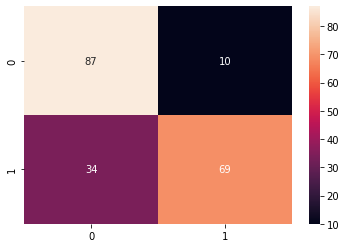

In [19]:
cm = confusion_matrix(y_test,model.predict(X_test))
sns.heatmap(cm,annot=True)

In [20]:
print(accuracy_score(y_test,model.predict(X_test)))

0.78


In [21]:
joblib.dump(model,'/content/classifier_model.pkl')

['/content/classifier_model.pkl']

#Predict results using saved model

In [22]:
model_loaded= joblib.load('/content/classifier_model.pkl')

In [23]:
model_loaded.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(max_features=1420)),
                ('classifier', SVC())])

In [24]:
example_text = ["It's worst."]
example_result = model_loaded.predict(example_text)

print(example_result)

['Negative']


Predicted Correctly

In [25]:
example_text = ["It's best."]
example_result = model_loaded.predict(example_text)

print(example_result)

['Positive']


Predicted Correctly